In [36]:
 # ! pip install pandas-datareader
# ! pip install yfinance

import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import numpy as np
from numpy import array
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
from sklearn.metrics import mean_squared_error

In [37]:
# Set the start and end dates for the data retrieval
start = dt.datetime(2024, 1, 1)
end = dt.datetime(2024, 8, 31)

# Use 'yahoo' as the data source to download stock data for Apple (AAPL)
df = yf.download('AAPL', start=start, end=end)

# Print a list of the columns in the dataframe
print("\n")
print("List of columns:", df.columns)

# Display the last few rows of the dataframe
df.tail()

[*********************100%***********************]  1 of 1 completed



List of columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-26,226.759995,227.279999,223.889999,227.179993,227.179993,30602200
2024-08-27,226.000000,228.850006,224.889999,228.029999,228.029999,35934600
2024-08-28,227.919998,229.860001,225.679993,226.490005,226.490005,38052200
2024-08-29,230.100006,232.919998,228.880005,229.789993,229.789993,51906300
2024-08-30,230.190002,230.399994,227.479996,229.000000,229.000000,52990800


(168, 1)


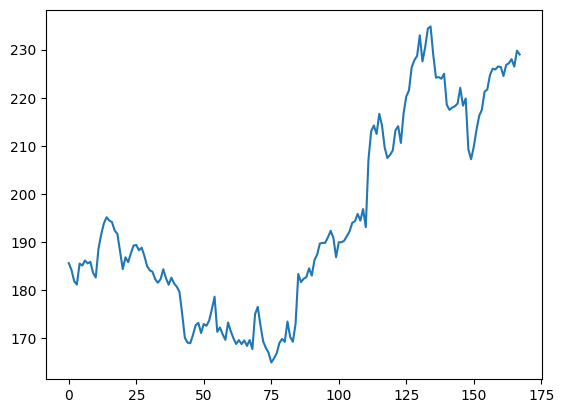

In [38]:
# Create a new DataFrame containing only the 'Close' column from the stock data
df_filtered = pd.DataFrame(df.reset_index()['Close'])

# Print the shape (rows, columns) of the filtered DataFrame
print(df_filtered.shape)

# Plot the 'Close' prices over time
plt.plot(df_filtered)
plt.show()


In [39]:
# Initialize the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the filtered data and apply the scaler
df_scaled = scaler.fit_transform(np.array(df_filtered).reshape(-1, 1))

# Print the shape of the scaled data
print(df_scaled.shape)

# Split the data into training and testing sets (65% for training)
training_size = int(df_scaled.shape[0] * 0.65)
test_size = df_scaled.shape[0] - training_size

# Print the number of training and testing samples
print(training_size, test_size)

# Create training and testing datasets
train_data, test_data = df_scaled[:training_size, :], df_scaled[training_size:, :1]

# Print the shapes of the training and testing datasets
print(train_data.shape, test_data.shape)

# Function to create dataset with the given time steps
def create_dataset(dataset, time_step=1):
    # Initialize lists to hold the input (X) and output (Y) data
    dataX, dataY = [], []

    # Loop over the dataset and create sequences
    for i in range(len(dataset) - time_step - 1):
        # Create sequences of length 'time_step' from the dataset
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        # The next value after the sequence is the target (Y)
        dataY.append(dataset[(i + time_step), 0])

    # Convert lists to numpy arrays and return
    return np.array(dataX), np.array(dataY)

# Set the time step to 20 (how many previous values are considered for each prediction)
time_step = 20

# Create training dataset using the defined time step
X_train, y_train = create_dataset(train_data, time_step)

# Reshape the input to be [samples, time steps, features] for model compatibility
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape, y_train.shape)  # Print the shapes of the training input and output

# Create testing dataset using the same time step
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the input to be [samples, time steps, features] for model compatibility
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape, y_test.shape)  # Print the shapes of the testing input and output

# Define the Sequential model
model = Sequential()

# First LSTM layer with 50 units, return_sequences=True to return the full sequence
# Input shape is (20,1), meaning 20 time steps and 1 feature per time step
model.add(LSTM(50, return_sequences=True, input_shape=(20, 1)))

# Second LSTM layer with 50 units, return_sequences=True to stack more LSTMs
model.add(LSTM(50, return_sequences=True))

# Third LSTM layer with 50 units, return_sequences=False because this is the last LSTM layer
model.add(LSTM(50))

# Dense output layer with 1 unit to predict a single value
model.add(Dense(1))

# Compile the model with 'adam' optimizer and mean squared error as the loss function
model.compile(optimizer="adam", loss="mean_squared_error")

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,verbose=True)

(168, 1)
109 59
(109, 1) (59, 1)
(88, 20, 1) (88,)
(38, 20, 1) (38,)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0523 - val_loss: 0.4112
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0198 - val_loss: 0.1175
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0135 - val_loss: 0.0530
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0139 - val_loss: 0.1348
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0100 - val_loss: 0.2132
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0124 - val_loss: 0.2106
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0119 - val_loss: 0.1638
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0107 - val_loss: 0.1092
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0095 - val_loss: 0.0829
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0095 - val_loss: 0.0973
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0086 - val_loss: 0.1151
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0090 - val_loss: 0.1159


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Mean Squared Error: 0.003216738719830467
Testing Mean Squared Error: 0.07387919083628021


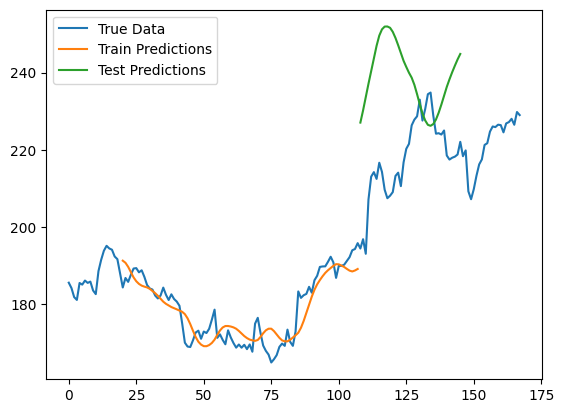

In [40]:
# Predict using the model for both training and testing datasets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Print the Mean Squared Error for training and testing predictions
print("Training Mean Squared Error:", mean_squared_error(y_train, train_predict))
print("Testing Mean Squared Error:", mean_squared_error(y_test, test_predict))

# Inverse transform the scaled predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


# Plotting
look_back = 20
# Shifting train predictions for plotting
train_Predict_Plot = np.empty_like(df_filtered)
train_Predict_Plot[:, :] = np.nan

# Ensuring that the size of train_predict matches the space available in the plot
train_predict_len = len(train_predict)
train_Predict_Plot[look_back:look_back + train_predict_len, :] = train_predict

# Shifting test predictions for plotting
test_Predict_Plot = np.empty_like(df_filtered)
test_Predict_Plot[:, :] = np.nan

# Ensuring that the size of test_predict matches the space available in the plot
test_predict_len = len(test_predict)
test_Predict_Plot[look_back + train_predict_len:look_back + train_predict_len + test_predict_len, :] = test_predict

# Plotting
plt.plot(df_filtered, label="True Data")
plt.plot(train_Predict_Plot, label="Train Predictions")
plt.plot(test_Predict_Plot, label="Test Predictions")
plt.legend()
plt.show()

59
<class 'numpy.ndarray'> (20, 1)
20
[1.1823065]
[0.634059003558781, 0.6048408951239188, 0.6419364454674277, 0.6919219778115986, 0.7338871400460341, 0.752363123300269, 0.8059295097344155, 0.8123746100070721, 0.8553422365509804, 0.8743912438774712, 0.8720995846777471, 0.8809794908958666, 0.8794040025141374, 0.8526209185693889, 0.885705956041055, 0.8905755679319816, 0.9027498162039493, 0.8806931974043888, 0.9279574117669682, 0.916642699603385, 1.1823065]
[1.1823065]
<class 'numpy.ndarray'> [0.6048409  0.64193645 0.69192198 0.73388714 0.75236312 0.80592951
 0.81237461 0.85534224 0.87439124 0.87209958 0.88097949 0.879404
 0.85262092 0.88570596 0.89057557 0.90274982 0.8806932  0.92795741
 0.9166427  1.18230653]
[0.634059003558781, 0.6048408951239188, 0.6419364454674277, 0.6919219778115986, 0.7338871400460341, 0.752363123300269, 0.8059295097344155, 0.8123746100070721, 0.8553422365509804, 0.8743912438774712, 0.8720995846777471, 0.8809794908958666, 0.8794040025141374, 0.8526209185693889, 0.88

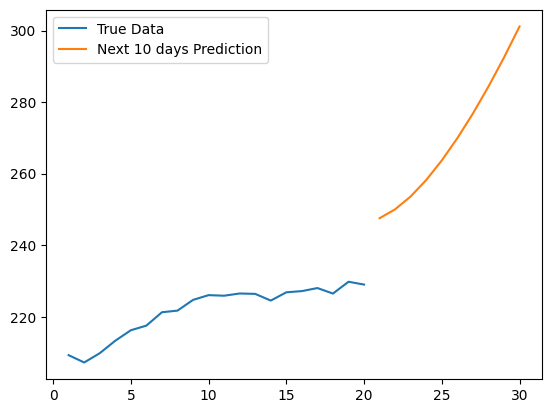

In [41]:
# Predict for the next 10 days

# Length of the test data
print(len(test_data))

# Prepare the initial input for prediction
x_input = test_data[39:].reshape(-1, 1)
print(type(x_input), x_input.shape)

# Flatten the input to a list for easy extension
temp_input = list(x_input.flatten())
print(len(temp_input))

# Initialize the output list and set parameters
lst_output = []
n_steps = 20  # Number of time steps for the LSTM model
i = 0

while i < 10:  # Loop for predicting the next 10 days
    if len(temp_input) > n_steps:
        # Use the last n_steps values from the temp_input for prediction
        x_input = np.array(temp_input[-n_steps:])
        print(type(x_input), x_input)

        # Reshape input for the LSTM model
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape(1, n_steps, 1)

        # Predict the next value
        y_hat = model.predict(x_input, verbose=False)
        temp_input.extend(y_hat[0])
        print(temp_input)

        # Append the prediction to the output list
        lst_output.extend(y_hat[0])
        print(lst_output)
        i += 1
    else:
        # If not enough values, reshape input accordingly
        x_input = x_input.reshape(1, n_steps, 1)

        # Predict the next value
        y_hat = model.predict(x_input, verbose=False)
        print(y_hat[0])

        # Extend the input list and output list
        temp_input.extend(y_hat[0])
        print(temp_input)
        lst_output.extend(y_hat[0])
        print(lst_output)
        i += 1

# Define the range for the true data and predictions
day_new = np.arange(1, 21)  # Days corresponding to the last 20 days of the dataset
day_pred = np.arange(21, 31)  # Days corresponding to the next 10 days

# Plot the true data (last 20 days of the dataset)
plt.plot(day_new, df_filtered[df_filtered.shape[0] - 20:], label="True Data")

# Inverse transform the predicted values to the original scale and plot them
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), label="Next 10 days Prediction")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

In [25]:
################################################################## END OF NOTEBOOK ##################################################################